## 台指日盤當沖策略(Result)

In [24]:
import polars as pl
import pandas as pd
from datetime import datetime, timedelta, time
import os
import glob
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 設定區
# =============================================================================
START_DATE = "2025-01-01"
END_DATE   = "2025-05-05"
SAVE_DIR   = r"C:\Users\USER\Desktop\雲端同步\Shioaji\Backtesting"
PATTERN    = os.path.join(SAVE_DIR, "stock_kbars_*.parquet")

BSR_THRESHOLD_LONG  = 1.1
BSR_THRESHOLD_SHORT = 0.9
stock_number = 5

tp_k_grid = 1.5
sl_k_grid = 4

STOCKS_TO_FETCH = ["2330", "2454", "2317", "2881", "2412", "2382", "2308", "2882", "2891", "3711"]
VOLUME_RATIO_LEVELS = {
    "high":     1.6,
    "mid_high": 1.2,
    "mid":      0.8,
    "mid_low":  0.5,
}

start_dt = datetime.strptime(START_DATE, "%Y-%m-%d").date()
end_dt   = datetime.strptime(END_DATE, "%Y-%m-%d").date()

# =============================================================================
# 1. 取最近 21 個交易日（含當日）→ 計算「前 20 日不含當日」的振幅統計
# =============================================================================
dates_df_full = (
    pl.scan_parquet(os.path.join(SAVE_DIR, "txf_kbars.parquet"))
    .with_columns(pl.col("ts").dt.date().alias("date"))
    .select("date")
    .filter(pl.col("date") <= end_dt)
    .unique().sort("date")
    .collect()
)

analysis_dates_df = dates_df_full.filter(
    (pl.col("date") >= start_dt) & (pl.col("date") <= end_dt)
)

pre_window_dates = (
    dates_df_full
      .filter(pl.col("date") < start_dt)
      .tail(40)
)

dates_df = pl.concat([pre_window_dates, analysis_dates_df])

start_trading   = dates_df["date"][0]    
analysis_dates  = analysis_dates_df["date"]

kbars_lazy = (
    pl.scan_parquet(os.path.join(SAVE_DIR, "txf_kbars.parquet"))
    .rename({"Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume"})
    .with_columns([
        pl.col("ts").cast(pl.Datetime("us")), 
        pl.col("ts").dt.date().alias("date"),
        pl.col("ts").dt.hour().alias("hour"),
        pl.col("ts").dt.minute().alias("minute"),
    ])
    .filter(
        (pl.col("date") >= start_trading) &
        (pl.col("date") <= end_dt) &
        (
            ((pl.col("hour") == 8)  & (pl.col("minute") >= 45)) |
            ((pl.col("hour") > 8)   & (pl.col("hour") < 13)) |
            ((pl.col("hour") == 13) & (pl.col("minute") <= 45))
        )
    )
    .drop(["hour", "minute"])
    .sort(["date","ts"])
)

minute_close_lazy = (
    kbars_lazy
    .with_columns(pl.col("ts").dt.truncate("1m").alias("minute_ts"))
    .group_by(["date", "minute_ts"])
    .agg(pl.col("close").last().alias("close"))
    .rename({"minute_ts": "ts"})
    .sort(["date","ts"])
    .with_columns([
        pl.col("close")
          .forward_fill().over("date")
    ])
    .lazy()
)

daily_range_lazy = (
    kbars_lazy
    .group_by("date")
    .agg([
        pl.col("high").max().alias("high_max"),
        pl.col("low").min().alias("low_min"),
    ])
    .with_columns([
        (pl.col("high_max") - pl.col("low_min")).alias("amplitude")
    ])
    .sort("date")
    .with_columns([
        pl.col("amplitude").shift(1).alias("amp_prev"),
        pl.col("amplitude").shift(1).rolling_max(window_size=20).alias("max"),
        pl.col("amplitude").shift(1).rolling_mean(window_size=20).alias("avg"),
        pl.col("amplitude").shift(1).rolling_min(window_size=20).alias("min"),
    ])
    .with_columns([
        pl.col("amp_prev").rank(method="average").over(
            pl.lit(1)
        ).alias("rank")  # dummy over for global rank
    ])
    .with_columns([
        pl.when(pl.col("rank") > 10)
          .then(None)
          .otherwise(pl.col("amp_prev"))
          .rolling_mean(window_size=20)
          .alias("top"),

        pl.when(pl.col("rank") <= (pl.len().over(pl.lit(1)) - 10))
          .then(pl.col("amp_prev"))
          .otherwise(None)
          .rolling_mean(window_size=20)
          .alias("bot")
    ])
    .select(["date", "amp_prev", "max", "avg", "min", "top", "bot", "amplitude"])
)

daily_range_df = daily_range_lazy.collect().to_pandas()
daily_range_df["top"] = daily_range_df["amp_prev"].rolling(20, min_periods=1) \
    .apply(lambda x: pd.Series(x).nlargest(10).mean(), raw=False)
daily_range_df["bot"] = daily_range_df["amp_prev"].rolling(20, min_periods=1) \
    .apply(lambda x: pd.Series(x).nsmallest(10).mean(), raw=False)
daily_range_df = daily_range_df.drop(columns=["rank"], errors="ignore")

daily_range_lazy = (
    pl.from_pandas(daily_range_df)
      .with_columns([
          pl.col("date").cast(pl.Date),
          pl.col("max"),
          pl.col("avg"),
          pl.col("min"),
          pl.col("top"),
          pl.col("bot"),
      ])
      .lazy()
)

# =============================================================================
# 2. 取最近 21 個交易日的 ticks → 每分鐘累積 vs 過去 20 日 KBARS 平均累積 → volume_ratio
# =============================================================================
kbars_min_cum = (
    kbars_lazy
    .with_columns(pl.col("ts").dt.truncate("1m").alias("minute_ts"))
    .group_by(["date", "minute_ts"])
    .agg(pl.col("volume").sum().alias("min_vol_k"))
    .sort(["date", "minute_ts"])
    .with_columns([
        pl.col("min_vol_k").cum_sum().over("date").alias("cum_vol_k"),
        pl.col("minute_ts").dt.strftime("%H:%M").alias("minute_str")
    ])
).cache() 

kbars_avg_cum = (
  kbars_min_cum
    .with_columns(
      pl.col("cum_vol_k")
        .shift(1)
        .rolling_mean(20)
        .over("minute_str")
        .alias("avg_cum_vol")
    )
    .group_by("minute_str")
    .agg(pl.col("avg_cum_vol").last())
)

volume_ratio_lazy = (
    kbars_min_cum
    .join(kbars_avg_cum, on="minute_str", how="left")
    .with_columns([
        (pl.col("cum_vol_k") / pl.col("avg_cum_vol")).alias("volume_ratio")
    ])
    .with_columns(
        pl.col("volume_ratio").fill_null(0).forward_fill().over("date")
    )
    .select([
        pl.col("date"),
        pl.col("minute_ts"),
        pl.col("cum_vol_k"),
        pl.col("avg_cum_vol"),
        pl.col("volume_ratio")
    ])
    .rename({
        "minute_ts": "ts",
        "cum_vol_k": "cum_vol"
    })
    .lazy()
)

# =============================================================================
# 3. 每分鐘內外盤成交比 bsr
# =============================================================================
ticks_base_lazy = (
    pl.scan_parquet(os.path.join(SAVE_DIR, "txf_ticks.parquet"))
    .with_columns([
        pl.col("ts").cast(pl.Datetime("us")).alias("ts"),
        pl.col("ts").dt.date().alias("date"),
        pl.col("volume"),
        pl.col("tick_type")
    ])
    .filter(
      pl.col("ts").dt.time().is_between(time(8,45), time(13,45)) &
      pl.col("tick_type").is_in([1,2])
    )
    .sort(["date","ts"])
    .with_columns([
        pl.arange(0, pl.len()).over("date").alias("row_idx")    
    ])
    .filter(pl.col("row_idx") > 0)                                   
    .drop("row_idx")                                               
    .lazy()
)

daily_bsr_lazy = (
    ticks_base_lazy
    .with_columns([
      pl.when(pl.col("tick_type")==1)
        .then(pl.col("volume")).otherwise(0)
        .cum_sum().over("date").alias("outer_cum"),

      pl.when(pl.col("tick_type")==2)
        .then(pl.col("volume")).otherwise(0)
        .cum_sum().over("date").alias("inner_cum"),
    ])
    .with_columns([
      pl.when(pl.col("inner_cum")==0)
        .then(None)
        .otherwise(pl.col("outer_cum")/pl.col("inner_cum"))
        .alias("bsr")
    ])
    .with_columns(pl.col("ts").dt.truncate("1m").alias("minute_ts"))
    .group_by(["date","minute_ts"])
    .agg(pl.col("bsr").last())
    .sort(["date","minute_ts"])
    .rename({"minute_ts":"ts"})
    .with_columns(pl.col("bsr").forward_fill().over("date"))
)

# =============================================================================
# 4. 計算權值股紅K比例 + TSMC 判斷
# =============================================================================
parquet_paths = glob.glob(PATTERN)
stock_lfs = []
for path in parquet_paths:
    sid = os.path.basename(path).split("_")[-1].replace(".parquet", "")
    lf = (
        pl.read_parquet(path).lazy()
        .rename({"Open": "open", "Close": "close"})
        .with_columns([
            pl.col("ts").cast(pl.Datetime),
            pl.col("ts").dt.date().alias("date"),
            pl.lit(sid).alias("sid")
        ])
    )
    stock_lfs.append(lf)

stock_lazy = (
    pl.concat(stock_lfs)
    .filter(pl.col("sid").is_in(STOCKS_TO_FETCH))
)

opening_price = (
    stock_lazy
    .filter(pl.col("ts").dt.time() >= datetime.strptime("09:00", "%H:%M").time())
    .sort(["sid", "date", "ts"])
    .group_by(["sid", "date"])
    .agg(pl.col("open").first().alias("day_open"))
)

minute_close = (
    stock_lazy
    .with_columns(pl.col("ts").dt.truncate("1m").alias("minute_ts"))
    .group_by(["sid","date","minute_ts"])
    .agg(pl.col("close").last().alias("minute_close"))
)


minute_status_lazy = (
    minute_close
    .join(opening_price, on=["sid", "date"])
    .with_columns((pl.col("minute_close") > pl.col("day_open")).alias("is_red"))
)

minute_status_lazy = (
    minute_close
    .join(opening_price, on=["sid","date"])
    .with_columns([
        pl.col("minute_ts").alias("ts"),
        (pl.col("minute_close") > pl.col("day_open")).alias("is_red")
    ])
)

tsmc_status_lazy = (
    minute_status_lazy
    .filter(pl.col("sid") == "2330")
    .select(["date","ts","is_red"])
    .rename({"is_red":"tsmc_red"})
)

summary_lazy = (
    minute_status_lazy
    .group_by(["date","ts"])
    .agg(pl.col("is_red").sum().alias("is_red"))
    .join(tsmc_status_lazy, on=["date","ts"], how="left")
    .with_columns([
      pl.col("is_red")    .forward_fill().over("date"),
      pl.col("tsmc_red") .forward_fill().over("date")
    ])
)

# =============================================================================
# 5. 合併所有指標
# =============================================================================
joined_all = (
    volume_ratio_lazy
    .join(daily_range_lazy, on="date", how="left")
    .join(daily_bsr_lazy,     on=["date","ts"], how="left")
    .join(minute_close_lazy,  on=["date","ts"], how="left")
    .join(summary_lazy,       on=["date","ts"], how="left")
    .with_columns(pl.col("ts").cast(pl.Datetime("us")))
    .filter(pl.col("ts").dt.time().is_between(time(8,45), time(13,45)))
)

float_cols = [
    "cum_vol","avg_cum_vol","volume_ratio",
    "amp_prev","max","avg","min","top","bot","amplitude",
    "bsr","close"
]
int_cols = ["is_red"]      
bool_cols = ["tsmc_red"]

joined_filled = (
    joined_all
    .with_columns([
        pl.col(c)
          .forward_fill().over("date")
          .fill_null(0.0)
          .alias(c)
        for c in float_cols
    ] + [
        pl.col(c)
          .forward_fill().over("date")
          .fill_null(0)
          .alias(c)
        for c in int_cols
    ] + [
        pl.col(c)
          .forward_fill().over("date")
          .fill_null(False)
          .alias(c)
        for c in bool_cols
    ])
)

joined_lazy = joined_filled.filter(
  pl.col("date").is_between(
    datetime.strptime(START_DATE, "%Y-%m-%d").date(),
    datetime.strptime(END_DATE,   "%Y-%m-%d").date()
  )
)

# =============================================================================
# 6. 產生符合條件的進場點（含 bsr 遞增 / 遞減規則）
# =============================================================================
kbars_seg = (
    kbars_lazy
      .filter(pl.col("ts").dt.time() >= time(8,45))
      .with_columns([
          pl.col("high").cum_max().over("date").alias("seg_high"),
          pl.col("low" ).cum_min().over("date").alias("seg_low"),
      ])
      .select(["date", "ts", "seg_high", "seg_low"])
)

entry_candidates = (    
    joined_lazy
    .filter(~pl.col("ts").dt.time().is_between(time(8,45), time(9,0)))
    .filter(pl.col("bsr").is_not_null())
    .filter(
        (
            (pl.col("tsmc_red") == True) &
            (pl.col("is_red")  > stock_number) &
            (pl.col("bsr")     > BSR_THRESHOLD_LONG)
        ) |
        (
            (pl.col("tsmc_red") == False) &
            (pl.col("is_red")  < stock_number) &
            (pl.col("bsr")     < BSR_THRESHOLD_SHORT)
        )
    )
    .with_columns([
        pl.col("ts").alias("entry_time"),
        pl.col("close").alias("entry"),
        pl.when(pl.col("tsmc_red") & (pl.col("is_red") > stock_number))
          .then(pl.lit("long"))
          .otherwise(pl.lit("short"))
          .alias("side"),
        pl.col("volume_ratio"),
        pl.col("bsr"),
    ])
    .sort("entry_time")     
)

entry_lazy = (
    entry_candidates
    .with_columns([
        pl.when(pl.col("side") == "long")
          .then(pl.col("bsr"))
          .otherwise(None)
          .cum_max()
          .shift(1)           
          .alias("prev_max_long"),
        pl.when(pl.col("side") == "short")
          .then(pl.col("bsr"))
          .otherwise(None)
          .cum_min()
          .shift(1)
          .alias("prev_min_short"),
    ])
    .filter(
        (
            (pl.col("side") == "long") &
            (
                pl.col("prev_max_long").is_null() |  
                (pl.col("bsr") > pl.col("prev_max_long")) 
            )
        )
        |
        (
            (pl.col("side") == "short") &
            (
                pl.col("prev_min_short").is_null() |   
                (pl.col("bsr") < pl.col("prev_min_short"))  
            )
        )
    )
    .drop(["prev_max_long", "prev_min_short"])
    .join_asof(
        kbars_seg.sort(["date", "ts"]),
        left_on  = "entry_time",
        right_on = "ts",
        by        = "date",
        strategy  = "backward"
    )
    .with_columns(
        (pl.col("seg_high") - pl.col("seg_low")).alias("seg_amp")
    )
    .filter(pl.col("seg_amp") <= pl.col("avg"))
    .with_columns(
        pl.arange(0, pl.len()).over("date").alias("seq")   
    )
    .filter(pl.col("seq") < 3)                             
    .drop("seq")
)

# =============================================================================
# 7. 建立 future ticks 資料（用於動態 TP/SL 出場檢查）
# =============================================================================
future_base = (
    pl.scan_parquet(f"{SAVE_DIR}/txf_ticks.parquet")
    .with_columns([
        pl.col("ts").cast(pl.Datetime("us")).alias("future_time"),
        pl.col("ts").dt.date().alias("date"),
    ])
    .filter(
        pl.col("date").is_between(start_trading, end_dt) &
        (pl.col("future_time").dt.time() >= time(8, 45)) &
        (pl.col("future_time").dt.time() <= time(13, 45))
    )
    .select(["future_time", "close", "date"])
    .rename({"close": "future_close"})
)

future_lazy = (
    future_base
    .join_asof(
        joined_lazy
          .with_columns(pl.col("ts").alias("minute_ts"))
          .select([
              pl.col("date"),
              pl.col("minute_ts"),
              pl.col("bsr"), pl.col("volume_ratio"),
              pl.col("max"), pl.col("top"), pl.col("avg"),
              pl.col("bot"), pl.col("min")
          ])
          .sort(["date", "minute_ts"]),
        left_on  = "future_time",
        right_on = "minute_ts",
        by="date",
        strategy = "backward",
        tolerance = timedelta(minutes=2)        
    )
    .sort(["date", "future_time"])
    .with_columns(
        pl.col("volume_ratio").forward_fill().over("date")
    )
    .with_columns(pl.col("future_close").round(0).cast(pl.Int32))
)

# =============================================================================
# 8. 收集進場點與 future ticks，並執行動態 TP/SL 出場邏輯
# =============================================================================
entry_df = entry_lazy.collect().to_pandas()
future_df = future_lazy.collect().to_pandas()
future_df = future_df[future_df["future_close"].notna()]

exit_records = []

def compute_tp_sl_offset(vol, max_, top, avg, bot, min_):
    if vol > VOLUME_RATIO_LEVELS["high"]:
        return (max_ + top) / tp_k_grid, (max_ + top) / sl_k_grid
    elif vol > VOLUME_RATIO_LEVELS["mid_high"]:
        return (top + avg) / tp_k_grid, (top + avg) / sl_k_grid
    elif vol > VOLUME_RATIO_LEVELS["mid"]:
        return avg , avg / 2
    elif vol > VOLUME_RATIO_LEVELS["mid_low"]:
        return (avg + bot) / tp_k_grid, (avg + bot) / sl_k_grid
    else:
        return (bot + min_) / tp_k_grid, (bot + min_) / sl_k_grid

for _, row in entry_df.iterrows():
    last_vol = None
    date = row["date"]
    entry_time = row["entry_time"]
    entry_price = row["entry"]
    side = row["side"]
    cutoff_time = pd.Timestamp(f"{date} 13:30:00")
    top_amp    = row["top"]
    seg_high = row["seg_high"]
    seg_low = row["seg_low"]
    seg_amp = row["seg_amp"]
    
    fut_ticks = future_df[
        (future_df["date"] == date) &
        (future_df["future_time"] > entry_time) &
        (future_df["future_time"] <= cutoff_time)
    ]

    exit_time, exit_price, exit_type = None, None, "Close"
    tp_pts, sl_pts = None, None
    long_tp, long_sl, short_tp, short_sl = None, None, None, None

    if fut_ticks.empty:
        continue
    else:
        for _, tick in fut_ticks.iterrows():
            vol = tick["volume_ratio"]
            if pd.isna(vol):
                vol = last_vol                  
            else:
                last_vol = vol                     

            if vol is None:                
                continue

            tp_offset, sl_offset = compute_tp_sl_offset(
                vol, tick["max"], tick["top"],
                tick["avg"], tick["bot"], tick["min"]
            )
            if pd.isna(tp_offset) or pd.isna(sl_offset):
                continue
            if seg_amp >= (top_amp/2):
                tp_offset /= 2
                sl_offset /= 2
            
            tp_pts, sl_pts = int(round(tp_offset)), int(round(sl_offset))

            if side == "long":
                tp_price = entry_price + tp_offset
                sl_price = entry_price - sl_offset
                long_tp, long_sl = int(round(tp_price)), int(round(sl_price))
                if tick["future_close"] >= tp_price:
                    exit_time, exit_price, exit_type = tick["future_time"], tp_price, "TP"
                    break
                elif tick["future_close"] <= sl_price:
                    exit_time, exit_price, exit_type = tick["future_time"], sl_price, "SL"
                    break
            else:
                tp_price = entry_price - tp_offset
                sl_price = entry_price + sl_offset
                short_tp, short_sl = int(round(tp_price)), int(round(sl_price))
                if tick["future_close"] <= tp_price:
                    exit_time, exit_price, exit_type = tick["future_time"], tp_price, "TP"
                    break
                elif tick["future_close"] >= sl_price:
                    exit_time, exit_price, exit_type = tick["future_time"], sl_price, "SL"
                    break

        if exit_time is None:
            last_tick = fut_ticks.iloc[-1]
            tp_offset, sl_offset = compute_tp_sl_offset(
                last_tick["volume_ratio"], last_tick["max"], last_tick["top"],
                last_tick["avg"], last_tick["bot"], last_tick["min"]
            )
            if pd.isna(tp_offset) or pd.isna(sl_offset):
                continue
            tp_pts, sl_pts = int(round(tp_offset)), int(round(sl_offset))
            exit_time = last_tick["future_time"]
            exit_price = last_tick["future_close"]
            if side == "long":
                long_tp = int(round(entry_price + tp_offset))
                long_sl = int(round(entry_price - sl_offset))
            else:
                short_tp = int(round(entry_price - tp_offset))
                short_sl = int(round(entry_price + sl_offset))

    pnl = exit_price - entry_price if side == "long" else entry_price - exit_price

    exit_records.append({
        "entry_time": entry_time,
        "exit_time": exit_time,
        "type": exit_type,
        "date": date,
        "side": side,
        "hold": entry_price,
        "long_tp": long_tp if side == "long" else None,
        "long_sl": long_sl if side == "long" else None,
        "short_tp": short_tp if side == "short" else None,
        "short_sl": short_sl if side == "short" else None,
        "pnl": int(round(pnl)),
        "tp_pts": tp_pts,
        "sl_pts": sl_pts,
        "vol%": round(row["volume_ratio"], 2),
        "bsr": round(row["bsr"], 2),
    })
print("進場訊號筆數：", len(exit_records))

# =============================================================================
# 9. 建立回測結果表格與統計欄位
# =============================================================================
exit_df = pd.DataFrame(exit_records)
exit_df["cumpnl"] = exit_df["pnl"].cumsum()

range_df = daily_range_lazy.collect().to_pandas()
range_df = range_df[["date", "max", "top", "avg", "bot", "min", "amplitude"]]
exit_df = exit_df.merge(range_df, on="date", how="left")

red_df = (
    summary_lazy
    .select(["date", "ts", "is_red"])
    .collect()
    .rename({"ts": "entry_time"})
    .to_pandas()
)

exit_df["entry_time_str"] = pd.to_datetime(exit_df["entry_time"]).dt.strftime("%H:%M")
red_df["entry_time_str"]  = pd.to_datetime(red_df["entry_time"]).dt.strftime("%H:%M")
exit_df = exit_df.merge(red_df[["date", "entry_time_str", "is_red"]], on=["date", "entry_time_str"], how="left")

if "is_red" in exit_df.columns:
    cols = exit_df.columns.tolist()
    cols.insert(cols.index("bsr") + 1, cols.pop(cols.index("is_red")))
    exit_df = exit_df[cols]

exit_df["entry"] = pd.to_datetime(exit_df["entry_time"]).dt.strftime("%H:%M")
exit_df["exit"]  = pd.to_datetime(exit_df["exit_time"]).dt.strftime("%H:%M")

final_cols = [
    "date", "entry", "exit", "type", "side", "hold",
    "long_tp", "long_sl", "short_tp", "short_sl",
    "bsr", "is_red", "vol%", "max", "top", "avg", "bot", "min", "amplitude",
    "tp_pts", "sl_pts", "pnl", "cumpnl"
]
exit_df = exit_df[final_cols]

for col in ["max", "top", "avg", "bot", "min", "amplitude"]:
    exit_df[col] = exit_df[col].round(0).astype("Int32")
for col in ["long_tp", "long_sl", "short_tp", "short_sl"]:
    exit_df[col] = exit_df[col].dropna().round(0).astype("Int32")

# =============================================================================
# 10. 輸出與檢視結果
# =============================================================================
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

print(exit_df)
exit_df.to_csv(r"C:\Users\USER\Desktop\雲端同步\Shioaji\Backtesting\exit_df.csv",
               index=False,
               encoding="utf-8-sig")
print("CSV 已經輸出到： exit_df.csv")

進場訊號筆數： 49
         date  entry   exit   type   side     hold  long_tp  long_sl  short_tp  short_sl   bsr  is_red  vol%   max  top  avg  bot  min  amplitude  tp_pts  sl_pts  pnl  cumpnl
0  2025-01-02  09:34  13:29  Close  short  22896.0     <NA>     <NA>     22685     23002  0.87       3  0.82   346  267  211  155   95        306     211     106   66      66
1  2025-01-02  09:39  13:29  Close  short  22878.0     <NA>     <NA>     22667     22984  0.86       4  0.99   346  267  211  155   95        306     211     106   48     114
2  2025-01-02  10:32  12:13     TP  short  22842.0     <NA>     <NA>     22736     22895  0.86       1  0.91   346  267  211  155   95        306     106      53  106     220
3  2025-01-03  09:01  09:17     SL   long  23065.0    23173    23011      <NA>      <NA>  1.78       9  1.16   346  275  215  155   95        203     108      54  -54     166
4  2025-01-07  10:51  13:29  Close  short  23834.0     <NA>     <NA>     23573     23932  0.88       3  0.71   402

<Figure size 1200x600 with 0 Axes>

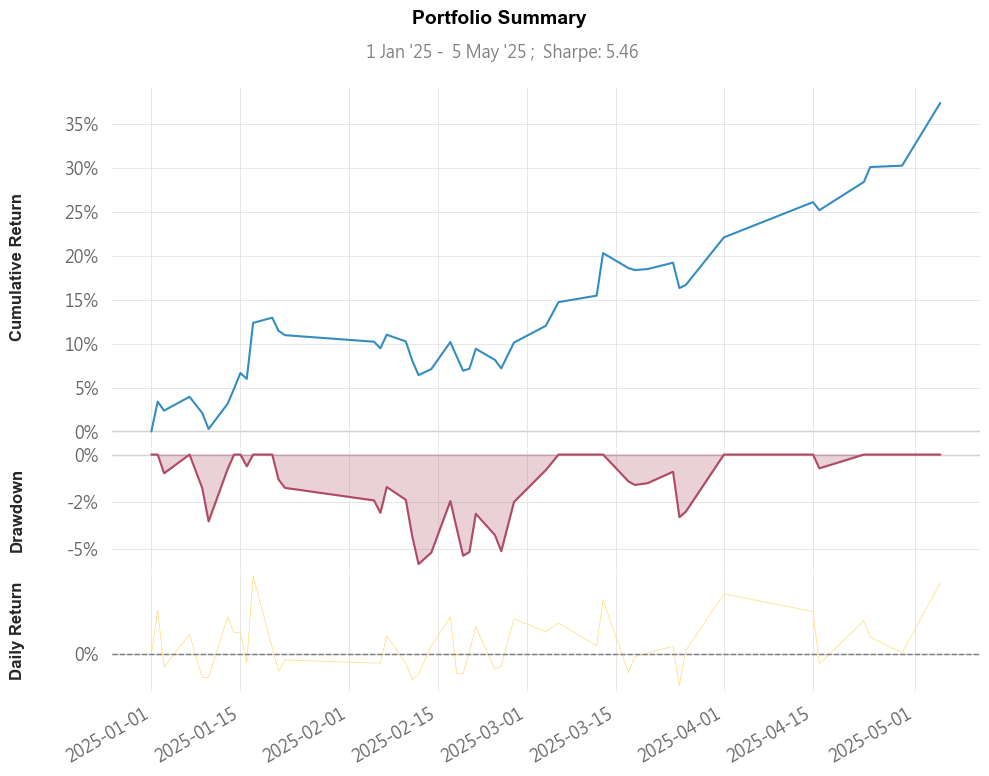

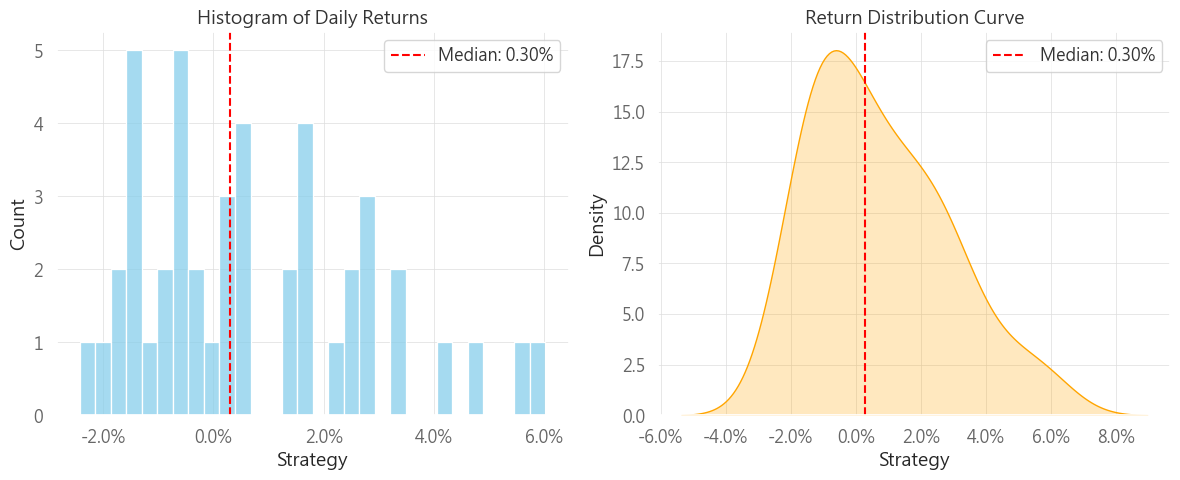

                    Strategy
------------------  ----------
Start Period        2025-01-02
End Period          2025-05-05
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   37.42%
CAGR﹪              91.8%

Sharpe              5.53
Prob. Sharpe Ratio  99.67%
Sortino             13.67
Sortino/√2          9.67
Omega               2.47

Max Drawdown        -5.79%
Longest DD Days     43

Gain/Pain Ratio     1.47
Gain/Pain (1M)      56.86

Payoff Ratio        1.81
Profit Factor       2.47
Common Sense Ratio  6.31
CPC Index           2.59
Tail Ratio          2.55
Outlier Win Ratio   2.73
Outlier Loss Ratio  1.89

MTD                 5.48%
3M                  23.84%
6M                  37.42%
YTD                 37.42%
1Y                  37.42%
3Y (ann.)           91.8%
5Y (ann.)           91.8%
10Y (ann.)          91.8%
All-time (ann.)     91.8%

Avg. Drawdown       -2.5%
Avg. Drawdown Days  10
Recovery Factor     5.68
Ulcer Index         0.03
Serenity Index      5.59


In [260]:
# =============================================================================
# 11. 回測績效計算與視覺化
# =============================================================================
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
import seaborn as sns
import pandas as pd
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 每筆交易的合約價值與手續費
exit_df["contract_value"] = exit_df["hold"] * 50
exit_df["fee"] = 20 + 20 + (exit_df["contract_value"] * 0.0002)
exit_df["net_profit"] = exit_df["pnl"] * 50 - exit_df["fee"]

# 將每日損益合併
daily_net_profit = (exit_df.groupby("date")["net_profit"].sum().sort_index())

# 計算每日報酬
capital = 300000
daily_returns = daily_net_profit / capital

daily_returns.index = pd.to_datetime(daily_returns.index)
daily_returns = daily_returns.replace([float('inf'), float('-inf')], pd.NA).dropna()

plt.figure(figsize=(12, 6)); qs.plots.snapshot(daily_returns, show=True)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

median_val = daily_returns.median()

sns.histplot(daily_returns, bins=30, kde=False, ax=axs[0], color='skyblue')
axs[0].axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2%}')
axs[0].set_title("Histogram of Daily Returns")
axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[0].legend()

sns.kdeplot(daily_returns, fill=True, ax=axs[1], color='orange')
axs[1].axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2%}')
axs[1].set_title("Return Distribution Curve")
axs[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[1].legend()

plt.tight_layout()
plt.show()
qs.reports.metrics(daily_returns)

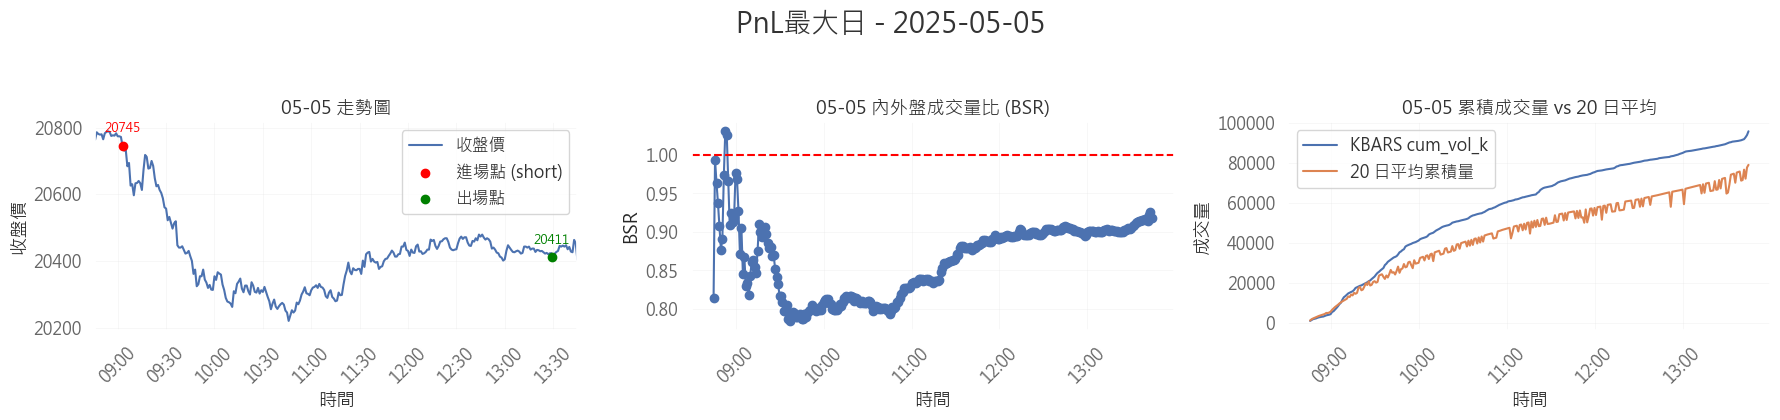

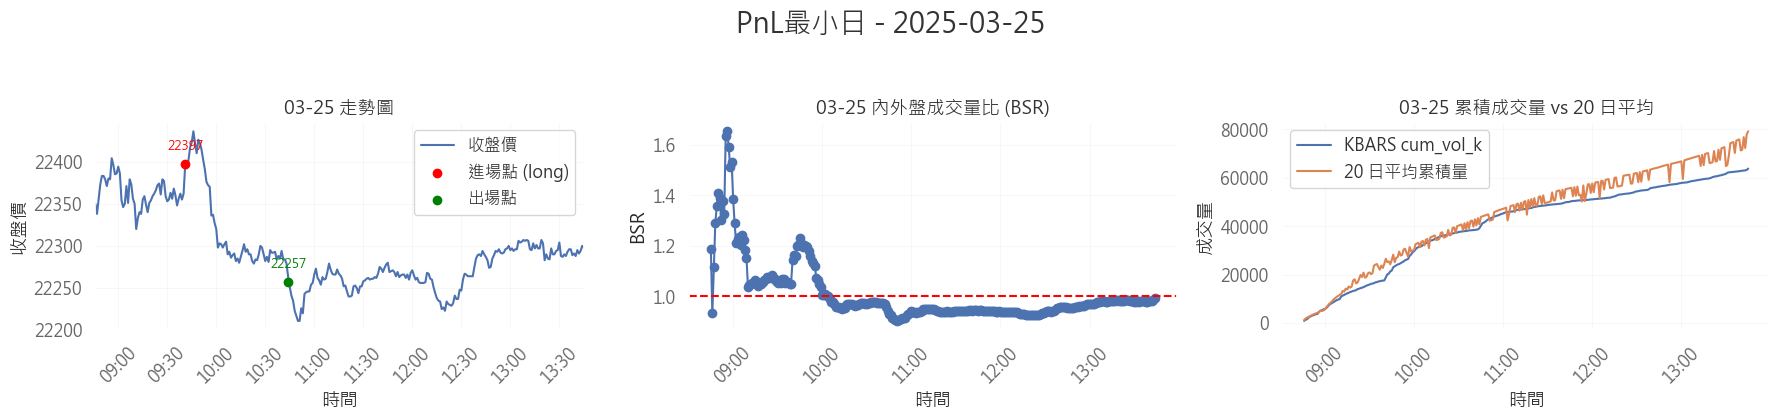

In [263]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

# 找出 PnL 最大與最小那天的日期
max_pnl_date = exit_df.loc[exit_df['pnl'].idxmax(), 'date']
min_pnl_date = exit_df.loc[exit_df['pnl'].idxmin(), 'date']
target_dates = [max_pnl_date, min_pnl_date]

# 開始畫圖
for d in target_dates:
    # 進場時間與點位
    entry_row = exit_df.loc[exit_df['date'] == d].iloc[0]
    entry_time = f"{d} {entry_row['entry']}"
    exit_time = f"{d} {entry_row['exit']}"
    entry_ts = pd.to_datetime(entry_time)
    exit_ts = pd.to_datetime(exit_time)
    entry_price = entry_row['hold']
    if side == "long":
        exit_price = entry_row['hold'] - entry_row['pnl']
    elif side == "short":
        exit_price = entry_row['hold'] + entry_row['pnl']
    side = entry_row['side'].lower() if 'side' in entry_row else "long"
    # 收盤價資料
    close_day = (
        minute_close_lazy
        .filter(pl.col("date") == d)
        .collect()
        .to_pandas()
    )
    close_day['ts'] = pd.to_datetime(close_day['ts'])

    # BSR 資料
    bsr_day = (
        daily_bsr_lazy
        .filter(pl.col("date") == d)
        .collect()
        .to_pandas()
    )
    bsr_day['ts'] = pd.to_datetime(bsr_day['ts'])

    # Volume 資料
    vol_day = (
        kbars_min_cum
        .filter(pl.col("date") == d)
        .with_columns(pl.col("cum_vol_k"), pl.col("minute_str"))
        .join(kbars_avg_cum, on="minute_str", how="left")
        .select(["date","minute_ts","cum_vol_k","avg_cum_vol"])
        .collect()
        .to_pandas()
    )
    vol_day['minute_ts'] = pd.to_datetime(vol_day['minute_ts'])

    # 畫圖
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=False)

    # 1. 分鐘收盤價 + 進場點
    axes[0].plot(close_day['ts'], close_day['close'], label="收盤價")
    axes[0].scatter([entry_ts], [entry_price], color='red', zorder=5, label=f'進場點 ({side})')
    axes[0].scatter([exit_ts], [exit_price], color='green', zorder=5, label='出場點')
    axes[0].annotate(f'{entry_price:.0f}', (entry_ts, entry_price), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red')
    axes[0].annotate(f'{exit_price:.0f}', (exit_ts, exit_price), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='green')
    
    # Set x-axis limits to match data range
    axes[0].set_xlim(close_day['ts'].min(), close_day['ts'].max())
    axes[0].set_title(f'{d.strftime("%m-%d")} 走勢圖')
    axes[0].set_xlabel('時間')
    axes[0].set_ylabel('收盤價')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))  # 日內時間
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # 2. BSR
    axes[1].plot(bsr_day['ts'], bsr_day['bsr'], marker='o')
    axes[1].set_title(f'{d.strftime("%m-%d")} 內外盤成交量比 (BSR)')
    axes[1].set_xlabel('時間')
    axes[1].set_ylabel('BSR')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    axes[1].axhline(1, color='red', linestyle='--', label=f'Median: {median_val:.2%}')
    axes[1].grid(alpha=0.3)

    # 3. Volume
    axes[2].plot(vol_day['minute_ts'], vol_day['cum_vol_k'], label='KBARS cum_vol_k')
    axes[2].plot(vol_day['minute_ts'], vol_day['avg_cum_vol'], label='20 日平均累積量')
    axes[2].set_title(f'{d.strftime("%m-%d")} 累積成交量 vs 20 日平均')
    axes[2].set_xlabel('時間')
    axes[2].set_ylabel('成交量')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    # 主標題
    if entry_row['pnl'] > 0:
        fig.suptitle(f'PnL最大日 - {d.strftime("%Y-%m-%d")}', y=1.05, fontsize=20)
    else:
        fig.suptitle(f'PnL最小日 - {d.strftime("%Y-%m-%d")}', y=1.05, fontsize=20)
    plt.tight_layout()
    plt.show()
